In [1]:
# general
import numpy as np
from numpy.lib.npyio import save

# visualization
import matplotlib.pyplot as plt
import cv2

# for images handling & manipulation
from skimage import measure
from scipy.ndimage import laplace
from PIL import Image

In [2]:
# use single well potential p1(s)=0.5*(s-1)^2, which is good for region-based model
DOUBLE_WELL = 'double-well'

# use double-well potential in Eq. (16), which is good for both edge and region based models
SINGLE_WELL = 'single-well'

In [3]:
class Level_Set: 

    def __init__(self, potential_function) -> None:
        self.pf = potential_function

    def initialise_params(self, image):
        """
        Parametes:
            preprocessed_img: Input image that has been preprocessed. It will be passed as a parameter 
            to the level set algorithm
        
        Returns:
            a dictionary containing all the parameters needed for the algorithm.
        """
        # initialize LSF as binary step function
        c0 = 2
        initial_lsf = c0 * np.ones(image.shape)
        # generate the initial region R0 as two rectangles
        initial_lsf[0:10, 0:10] = -c0 # top left corner

        # parameters
        return {
            'img': image,
            'initial_lsf': initial_lsf,
            'timestep': 7,  # time step
            'iter_inner': 30,
            'iter_outer': 35,
            'lmda': 6.5,  # coefficient of the weighted length term L(phi)
            'alfa': -3.5,  # coefficient of the weighted area term A(phi)
            'epsilon': 1.2,  # parameter that specifies the width of the DiracDelta function
            'sigma': 0.8,  # scale parameter in Gaussian kernel
            'potential_function': self.pf,
        }

    def find_lsf(self, img: np.ndarray, initial_lsf: np.ndarray, timestep=1, iter_inner=10, iter_outer=30, lmda=5,
                alfa=-3, epsilon=1.5, sigma=0.8, potential_function=DOUBLE_WELL):
        """
        Parameters:
            img: Input image as a grey scale uint8 array (0-255).
            initial_lsf: Array as same size as the img that contains the seed points for the LSF.
            timestep: Time Step.
            iter_inner: How many iterations to run drlse before showing the output.
            iter_outer: How many iterations to run the iter_inner.
            lmda: coefficient of the weighted length term L(phi).
            alfa: coefficient of the weighted area term A(phi).
            epsilon: parameter that specifies the width of the DiracDelta function.
            sigma: scale parameter in Gaussian kernal.
            potential_function: The potential function to use in drlse algorithm. Should be SINGLE_WELL or DOUBLE_WELL.
            
        Returns:
            Phi value that indicates the boundary drawn. Will be used to segment the image.
        """
        if len(img.shape) != 2:
            raise Exception("Input image should be a gray scale one")

        if img.shape != initial_lsf.shape:
            raise Exception("Input image and the initial LSF should be in the same shape")

        if potential_function != SINGLE_WELL and potential_function != DOUBLE_WELL:
            raise Exception("Potential function should be either SINGLE-WELL or DOUBLE-WELL")

        # parameters
        mu = 0.2 / timestep  # coefficient of the distance regularization term R(phi)

        img_smooth = np.array(img, dtype='float32')

        [Iy, Ix] = np.gradient(img_smooth)
        f = np.square(Ix) + np.square(Iy)
        g = 1 / (1 + f)  # edge indicator function.

        # initialize LSF as binary step function
        phi = initial_lsf.copy()

        if potential_function != SINGLE_WELL:
            potential_function = DOUBLE_WELL  # default choice of potential function

        # start level set evolution
        for n in range(iter_outer):
            phi = self.drlse_edge(phi, g, lmda, mu, alfa, epsilon, timestep, iter_inner, potential_function)

        # refine the zero level contour by further level set evolution with alfa=0
        alfa = 0
        iter_refine = 10
        phi = self.drlse_edge(phi, g, lmda, mu, alfa, epsilon, timestep, iter_refine, potential_function)
        return phi

    def drlse_edge(self, phi_0, g, lmda, mu, alfa, epsilon, timestep, iters, potential_function):  # Updated Level Set Function
        """
        Parameters:
            phi_0: level set function to be updated by level set evolution.
            g: edge indicator function.
            lmda: weight of the weighted length term.
            mu: weight of distance regularization term.
            alfa: weight of the weighted area term.
            epsilon: width of Dirac Delta function.
            timestep: time step.
            iters: number of iterations.
            potential_function: choice of potential function in distance regularization term.
                                As mentioned in the above paper, two choices are provided: potentialFunction='single-well' or
                                potentialFunction='double-well', which correspond to the potential functions p1 (single-well)
                                and p2 (double-well), respectively.
        
        Returns:
            An updated level set function.
                    
        """
        phi = phi_0.copy()
        [vy, vx] = np.gradient(g)
        for k in range(iters):
            phi = self.neumann_bound_cond(phi)
            [phi_y, phi_x] = np.gradient(phi)
            s = np.sqrt(np.square(phi_x) + np.square(phi_y))
            delta = 1e-10
            n_x = phi_x / (s + delta)  # add a small positive number to avoid division by zero
            n_y = phi_y / (s + delta)
            curvature = self.div(n_x, n_y)

            if potential_function == SINGLE_WELL:
                dist_reg_term = laplace(phi, mode='nearest') - curvature  # compute distance regularization term in equation (13) with the single-well potential p1.
            elif potential_function == DOUBLE_WELL:
                dist_reg_term = self.dist_reg_p2(phi)  # compute the distance regularization term in eqaution (13) with the double-well potential p2.
            else:
                raise Exception('Error: Wrong choice of potential function. Please input the string "single-well" or "double-well" in the drlse_edge function.')
            dirac_phi = self.dirac(phi, epsilon)
            area_term = dirac_phi * g  # balloon/pressure force
            edge_term = dirac_phi * (vx * n_x + vy * n_y) + dirac_phi * g * curvature
            phi += timestep * (mu * dist_reg_term + lmda * edge_term + alfa * area_term)
        return phi


    def dist_reg_p2(self, phi):
        """
        Compute the distance regularization term with the DOUBLE WELL potential p2 in equation (16).
        
        Parameter:
            phi: level set function to be updated by level set evolution.
            
        Returns
            Distance regression term in equation (13).
        
        """
        [phi_y, phi_x] = np.gradient(phi)
        s = np.sqrt(np.square(phi_x) + np.square(phi_y))
        a = (s >= 0) & (s <= 1)
        b = (s > 1)
        ps = a * np.sin(2 * np.pi * s) / (2 * np.pi) + b * (s - 1)  # compute first order derivative of the double-well potential p2 in equation (16)
        dps = ((ps != 0) * ps + (ps == 0)) / ((s != 0) * s + (s == 0))  # compute d_p(s)=p'(s)/s in equation (10). As s-->0, we have d_p(s)-->1 according to equation (18)
        return self.div(dps * phi_x - phi_x, dps * phi_y - phi_y) + laplace(phi, mode='nearest')


    def div(self, nx: np.ndarray, ny: np.ndarray) -> np.ndarray:
        """
        Compute the curvature to the level set function.
        Returns:
            The curvature of the level set function. 
        """
        [_, nxx] = np.gradient(nx)
        [nyy, _] = np.gradient(ny)
        return nxx + nyy


    def dirac(self, x: np.ndarray, sigma: np.ndarray) -> np.ndarray:
        """
        Parameters:
            x: level set function to be updated by level set evolution.
            sigma: Width of Dirac Delta function.
            
        Returns:
            Updated function that will be used to calculate the area and the edge term.
        """
        f = (1 / 2 / sigma) * (1 + np.cos(np.pi * x / sigma))
        b = (x <= sigma) & (x >= -sigma)
        return f * b


    def neumann_bound_cond(self, f):
        """
        Make a function satisfy Neumann boundary condition.
        
        Parameter: 
            f: level set function to be updated by level set evolution.
        Return:
            A level set function that satisfy neumann boundary condition.
        """
        g = f.copy()

        g[np.ix_([0, -1], [0, -1])] = g[np.ix_([2, -3], [2, -3])]
        g[np.ix_([0, -1]), 1:-1] = g[np.ix_([2, -3]), 1:-1]
        g[1:-1, np.ix_([0, -1])] = g[1:-1, np.ix_([2, -3])]
        return g

    def segment_image(self, phi: np.ndarray, img: np.ndarray):
        """
        Assign the pixel within the boundary to be black. Save the output image. Return the segmented and original image for 
        visualisation purpose.
        
        Parameters:
            phi: finalised level set function (provide the boundary drawn).
            img: img to be segmented.
            filename: file name used to save the image.
        
        Returns:
            Tuple that contains the numpy arrays for the original image and the segmented image
        """
        contours = measure.find_contours(phi, 0)
        max_of_y = int(np.round(max(contours[0], key=lambda x: x[0]))[0])
        # contains the rightmost pixel at that particular y 
        record_array = [0] * (max_of_y + 1)
        for contour in contours[0]:
            x, y = int(contour[1]), round(contour[0]) 
            if record_array[y] < x:
                record_array[y] = x
        for i in range(len(record_array)):
            for j in range(record_array[i]):
                img[i,j] = 0
        return img

    def run_level_set(self, image):
        params = self.initialise_params(image)
        phi = self.find_lsf(**params)
        f = open("phi.txt", 'w')
        for item in phi:
            f.write(str(item))
            f.write(",")
        f.close()
        return self.segment_image(phi, image)

### Testing: Level_Set.initialise_params

In [4]:
def test_initialise_params():
    image_data = cv2.imread("mdb019.png", 0)
    ls = Level_Set('double-well')
    return ls.initialise_params(image_data)

In [5]:
test_initialise_params()

{'img': array([[173, 164, 164, ...,   0,   0,   0],
        [219, 211, 211, ...,   0,   0,   0],
        [213, 210, 211, ...,   0,   0,   0],
        ...,
        [174, 173, 159, ...,   0,   0,   0],
        [166, 164, 161, ...,   0,   0,   0],
        [162, 155, 159, ...,   0,   0,   0]], dtype=uint8),
 'initial_lsf': array([[-2., -2., -2., ...,  2.,  2.,  2.],
        [-2., -2., -2., ...,  2.,  2.,  2.],
        [-2., -2., -2., ...,  2.,  2.,  2.],
        ...,
        [ 2.,  2.,  2., ...,  2.,  2.,  2.],
        [ 2.,  2.,  2., ...,  2.,  2.,  2.],
        [ 2.,  2.,  2., ...,  2.,  2.,  2.]]),
 'timestep': 7,
 'iter_inner': 30,
 'iter_outer': 35,
 'lmda': 6.5,
 'alfa': -3.5,
 'epsilon': 1.2,
 'sigma': 0.8,
 'potential_function': 'double-well'}

### Test 1: Level_Set.find_lsf


#### Test 1a: Image must be a gray scale image, else excetion will be raised

In [6]:
def test_find_lsf_gray_scale():
    sample_three_dimensional_image = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])
    ls = Level_Set('double-well')
    params = ls.initialise_params(sample_three_dimensional_image)
    ls.find_lsf(**params)

In [7]:
test_find_lsf_gray_scale()

Exception: Input image should be a gray scale one

#### Test 1b: Image and the initial level set function should have the same shape

In [8]:
def test_find_lsf_shape_mismatched():
    image_data = cv2.imread("mdb019.png", 0)
    ls = Level_Set('double-well')
    params = ls.initialise_params(image_data)
    params["initial_lsf"] = 2 * np.ones((256,191))
    ls.find_lsf(**params)

In [9]:
test_find_lsf_shape_mismatched()

Exception: Input image and the initial LSF should be in the same shape

#### Test 1c: Use potential function other than "SINGLE-WELL" and "DOUBLE-WELL"

In [10]:
def test_find_lsf_potential_function():
    image_data = cv2.imread("mdb019.png", 0)
    ls = Level_Set('third-well')
    params = ls.initialise_params(image_data)
    ls.find_lsf(**params)

In [11]:
test_find_lsf_potential_function()

Exception: Potential function should be either SINGLE-WELL or DOUBLE-WELL

### Test 2: Segment Image

In [12]:
def test_segment_image():
    image_data = cv2.imread("mdb019.png", 0)
    ls = Level_Set('double-well')
    params = ls.initialise_params(image_data)
    phi = ls.find_lsf(**params)
    return ls.segment_image(phi, image_data)

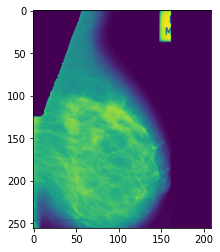

In [13]:
segmented_image = test_segment_image()
plt.imshow(segmented_image)
plt.show()

### Test 3: Different file formats

In [14]:
def test_level_set_with_files(image_path):
    image_data = cv2.imread(image_path, 0)
    ls = Level_Set('double-well')
    params = ls.initialise_params(image_data)
    phi = ls.find_lsf(**params)
    segmented_image = ls.segment_image(phi, image_data)
    plt.imshow(segmented_image)
    plt.show()

#### .png

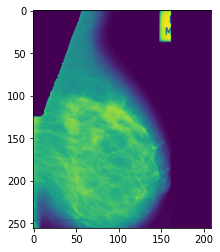

In [15]:
test_level_set_with_files("mdb019.png")

#### .jpg

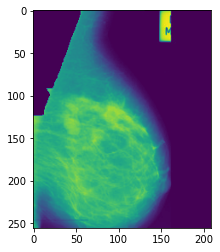

In [18]:
test_level_set_with_files("mdb019.jpg")

#### .jpeg

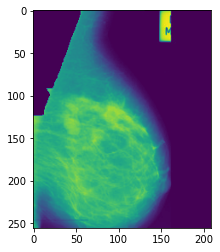

In [17]:
test_level_set_with_files("mdb019.jpeg")

#### .pgm

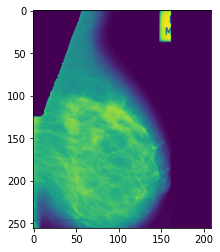

In [19]:
test_level_set_with_files("mdb019.pgm")